In [93]:
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from datetime import date
import pandas as pd
import sklearn
from sklearn.cluster import KMeans

In [94]:
TDATA = np.linspace(8, 512, 64) #ms units

noise_opt = True
SNR_value = 100

T21_center = 50
T22_center = 70

c1 = 0.4
c2 = 1 - c1

lower_bounds = [1,1]
upper_bounds = [150,150]

T21_range = np.arange(T21_center-30, T21_center+30+.001, 1)
T22_range = np.arange(T22_center-30, T22_center+30+.001, 1)

mT21, mT22 = np.meshgrid(T21_range, T22_range)

ob_weight = 100

repetitions = 100

multi_starts = 2

lambda_array = np.append([0], np.logspace(-5,0,100))

RRSS = r'RSS$^{1/2}$'
T21_label = r'$T_{21}$'
T22_label = r'$T_{22}$'
c1_label = r'$c_1$'
c2_label = r'$c_2$'
lamb_lab = r'$\lambda$'


if noise_opt:
    noise_info = f"SNR = {SNR_value}"
else:
    noise_info = "noiseless"

In [95]:
def G_biX(t, con_1, con_2, tau_1, tau_2): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return signal

def G_reg(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def G_lam(t, tau1, tau2):
        return np.append(G_biX(t, c1, c2, tau1, tau2), [lam*c1/SA, lam*c2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return G_lam

def J_biX(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

In [96]:
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def get_init_params():
    iT21 = np.random.uniform(lower_bounds[0],upper_bounds[0])
    iT22 = np.random.uniform(lower_bounds[1],upper_bounds[1])
    p0 = [iT21,iT22]
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS(input, func, popt, data):
    est_curve = func(input, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estimate_params(noisy_data, lamb):
    data_tilde = np.append(noisy_data,[0,0,0,0])

    init_params = get_init_params()

    popt, _, info_popt, _, _ = curve_fit(G_reg(lamb), TDATA, data_tilde, bounds = (lower_bounds, upper_bounds), p0=init_params, max_nfev = 4000, full_output = True)

    return popt, np.sum(info_popt['fvec']**2)

In [97]:
def format_fn(tick_val, tick_pos, labels = ""):
    if int(tick_val) < len(labels):
        return labels[int(tick_val)]
    else:
        return ''

# Nonregularized Case

In [98]:
true_signal = G_biX(TDATA, c1, c2, T21_center, T22_center)

surface_array = np.zeros([len(T22_range), len(T21_range)])

for iT21 in range(len(T21_range)):
    for iT22 in range(len(T22_range)):
        # if T21_range[iT21] <= T22_range[iT22]:
        temp_param = [c1, c2, T21_range[iT21], T22_range[iT22]]
        temp_RSS = calculate_RSS(TDATA, G_biX, temp_param, true_signal)
        surface_array[iT22, iT21] = temp_RSS
        # else:
        #     surface_array[iT22, iT21] = np.nan

trueP_RSS = calculate_RSS(TDATA, G_biX, [c1, c2, T21_center, T22_center], true_signal)

In [99]:
minimum_T2 = np.zeros([len(lambda_array), repetitions, 2])
minimum_RSS = np.zeros([len(lambda_array), repetitions])

for iLamb in trange(len(lambda_array)):

    lamb = lambda_array[iLamb]

    for rep in range(repetitions):

        noisey_sig = add_noise(true_signal, SNR_value)

        RSS_best = np.inf
        popt_best = np.zeros(2)

        for iMS in range(multi_starts):
            popt_temp, RSS_temp = estimate_params(noisey_sig, lamb)
            if RSS_temp < RSS_best:
                RSS_best = RSS_temp
                popt_best = popt_temp

    
        minimum_T2[iLamb,rep,:] = check_param_order(popt_best)
        minimum_RSS[iLamb,rep]  = RSS_best


100%|██████████| 101/101 [00:49<00:00,  2.04it/s]


Text(0.5, 1.0, 'True Signal for Biexponential Model\n$c_1$, $c_2$, $T_{21}$, $T_{22}$ = 0.4, 0.6, 50, 70')

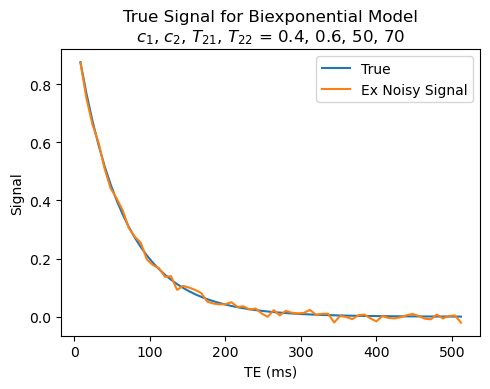

In [100]:
fig = plt.figure(figsize=(5,4), tight_layout=True)
plt.plot(TDATA, true_signal, label = "True")
plt.plot(TDATA, noisey_sig, label = "Ex Noisy Signal")
plt.xlabel(r'TE (ms)')
plt.ylabel('Signal')
plt.legend()
plt.title(f'True Signal for Biexponential Model\n{c1_label}, {c2_label}, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}')

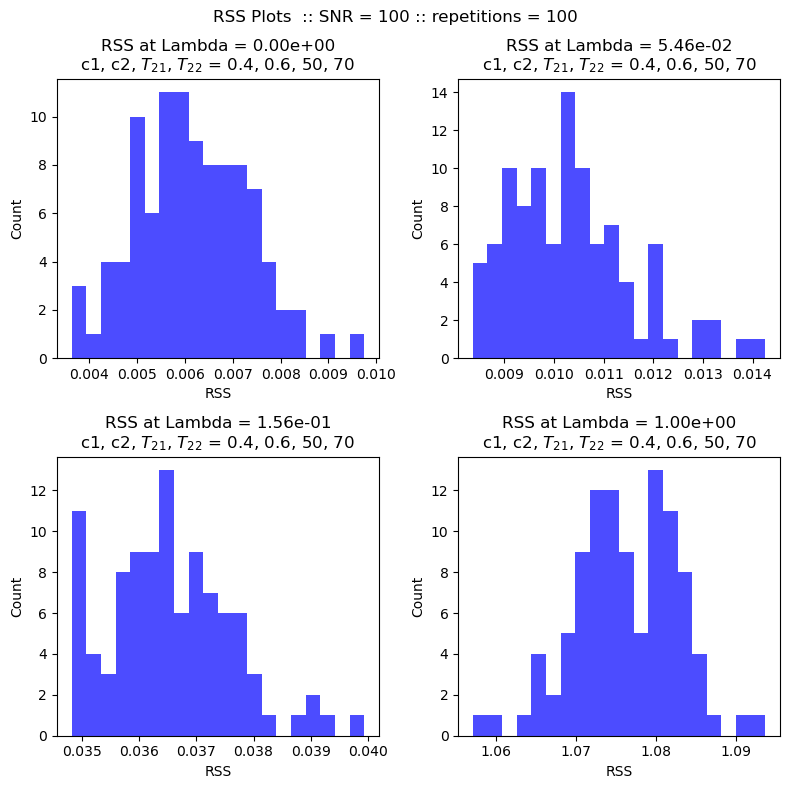

In [101]:
fig, ax = plt.subplots(2, 2, figsize=(8,8), tight_layout=True)
fig.suptitle(f"RSS Plots  :: {noise_info} :: repetitions = {repetitions}")

rootRSS = surface_array**(1/2)

lambs_ind = [0,3*len(lambda_array)//4, 5*len(lambda_array)//6, -1]

for i in range(len(lambs_ind)):
    lamb_oi_ind = lambs_ind[i]
    lambda_oi = lambda_array[lamb_oi_ind]
    ax[i//2, i%2].hist(x=minimum_RSS[lamb_oi_ind,:], bins=20, color='b', alpha = 0.7)
    ax[i//2, i%2].set_xlabel('RSS')
    ax[i//2, i%2].set_ylabel('Count')
    ax[i//2, i%2].set_title(f'RSS at Lambda = {lambda_oi:.2e}' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")

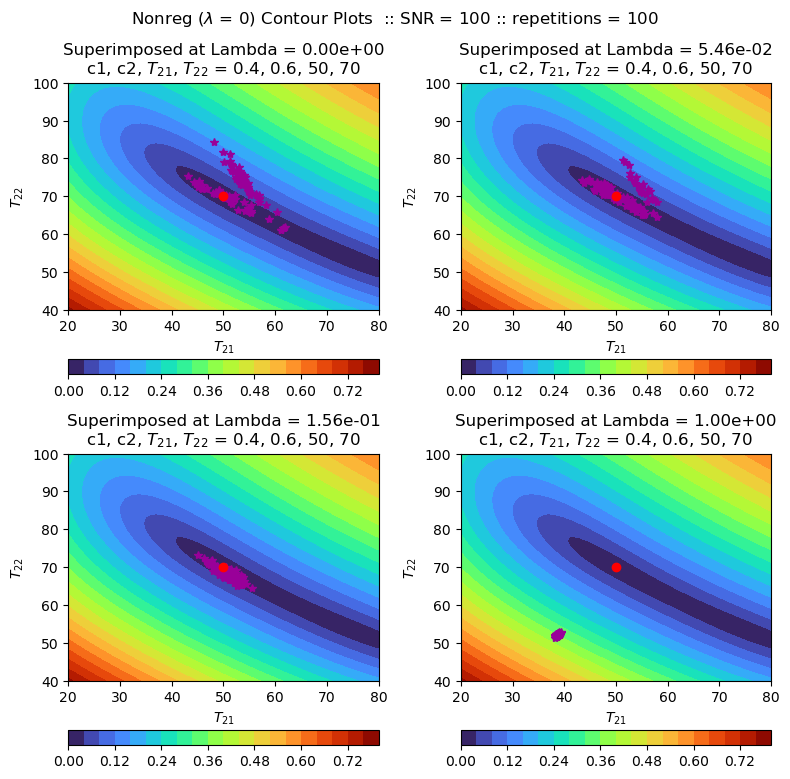

In [102]:
fig, ax = plt.subplots(2, 2, figsize=(8,8), tight_layout=True)
fig.suptitle(f"Nonreg ({lamb_lab} = 0) Contour Plots  :: {noise_info} :: repetitions = {repetitions}")

rootRSS = surface_array**(1/2)

lambs_ind = [0,3*len(lambda_array)//4, 5*len(lambda_array)//6, -1]

for i in range(len(lambs_ind)):
    lamb_oi_ind = lambs_ind[i]
    lambda_oi = lambda_array[lamb_oi_ind]
    cp = ax[i//2, i%2].contourf(mT21, mT22, rootRSS, 20, cmap = 'turbo')
    ax[i//2, i%2].plot(minimum_T2[lamb_oi_ind,:,0], minimum_T2[lamb_oi_ind,:,1], color = (0.6,0,0.6), marker = '*', label = 'Minimum', ls = '')
    ax[i//2, i%2].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
    ax[i//2, i%2].set_xlabel(T21_label)
    ax[i//2, i%2].set_ylabel(T22_label)
    ax[i//2, i%2].set_title(f'Superimposed at Lambda = {lambda_oi:.2e}' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
    fig.colorbar(cp, ax = ax[i//2, i%2], location = 'bottom')

/home/hamptong2/anaconda3/envs/BrainReg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


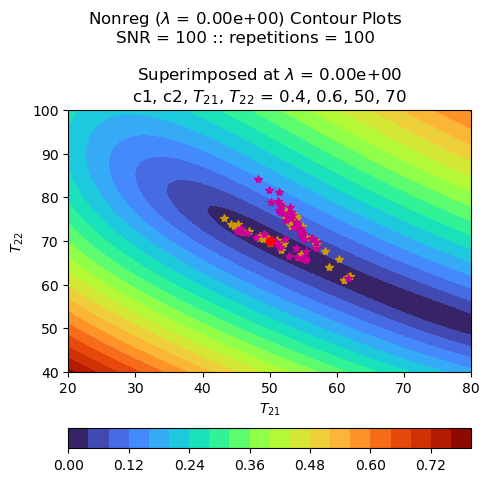

In [103]:
num_clusters = 2

kmeans = KMeans(n_clusters = num_clusters).fit(minimum_T2[lamb_oi_ind,:,:])

kmeans_return = kmeans.labels_
assert(len(set(kmeans_return))==num_clusters)
kmeans_centers = np.array(kmeans.cluster_centers_)
assert(len(kmeans_centers)==num_clusters)

lamb_oi_ind = 0#3*len(lambda_array)//4
lambda_oi = lambda_array[lamb_oi_ind]

fig, ax = plt.subplots(1,1, figsize=(5,5), tight_layout=True)
fig.suptitle(f"Nonreg ({lamb_lab} = {lambda_oi:.2e}) Contour Plots\n{noise_info} :: repetitions = {repetitions}")

cp = ax.contourf(mT21, mT22, rootRSS, 20, cmap = 'turbo')
ax.plot(minimum_T2[lamb_oi_ind,np.where(kmeans_return==0),0], minimum_T2[lamb_oi_ind,np.where(kmeans_return==0),1], color = (0.8,0.6,0), marker = '*', label = 'Minimum', ls = '')
ax.plot(minimum_T2[lamb_oi_ind,np.where(kmeans_return==1),0], minimum_T2[lamb_oi_ind,np.where(kmeans_return==1),1], color = (0.8,0,0.6), marker = '*', label = 'Minimum', ls = '')
ax.plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax.set_xlabel(T21_label)
ax.set_ylabel(T22_label)
ax.set_title(f'Superimposed at {lamb_lab} = {lambda_oi:.2e}' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax, location = 'bottom')

In [104]:
bias = np.mean(minimum_T2, axis = 1) - [T21_center, T22_center]
square_bias = bias**2
variance = np.var(minimum_T2, axis = 1)
MSE = square_bias + variance

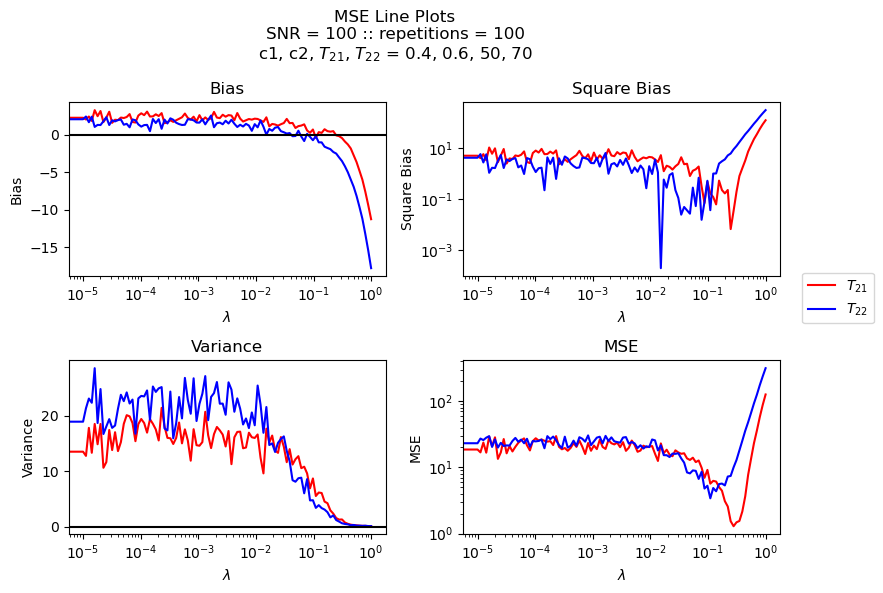

In [105]:
fig, ax = plt.subplots(2,2, figsize=(8,6), tight_layout=True)
fig.suptitle(f"MSE Line Plots\n{noise_info} :: repetitions = {repetitions}\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")


ax[0,0].semilogx(lambda_array, bias[:,0], color = 'r', ls = '-', label = T21_label)
ax[0,0].semilogx(lambda_array, bias[:,1], color = 'b', ls = '-', label = T22_label)
ax[0,0].axhline(y = 0, color = 'k')
ax[0,0].set_xlabel(lamb_lab)
ax[0,0].set_ylabel('Bias')
ax[0,0].set_title(f'Bias')

ax[0,1].loglog(lambda_array, square_bias[:,0], color = 'r', ls = '-', label = T21_label)
ax[0,1].loglog(lambda_array, square_bias[:,1], color = 'b', ls = '-', label = T22_label)
ax[0,1].axhline(y = 0, color = 'k')
ax[0,1].set_xlabel(lamb_lab)
ax[0,1].set_ylabel('Square Bias')
ax[0,1].set_title(f'Square Bias')

ax[1,0].semilogx(lambda_array, variance[:,0], color = 'r', ls = '-', label = T21_label)
ax[1,0].semilogx(lambda_array, variance[:,1], color = 'b', ls = '-', label = T22_label)
ax[1,0].axhline(y = 0, color = 'k')
ax[1,0].set_xlabel(lamb_lab)
ax[1,0].set_ylabel('Variance')
ax[1,0].set_title(f'Variance')

ax[1,1].loglog(lambda_array, MSE[:,0], color = 'r', ls = '-', label = T21_label)
ax[1,1].loglog(lambda_array, MSE[:,1], color = 'b', ls = '-', label = T22_label)
ax[1,1].axhline(y = 0, color = 'k')
ax[1,1].set_xlabel(lamb_lab)
ax[1,1].set_ylabel('MSE')
ax[1,1].set_title(f'MSE')

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.5))

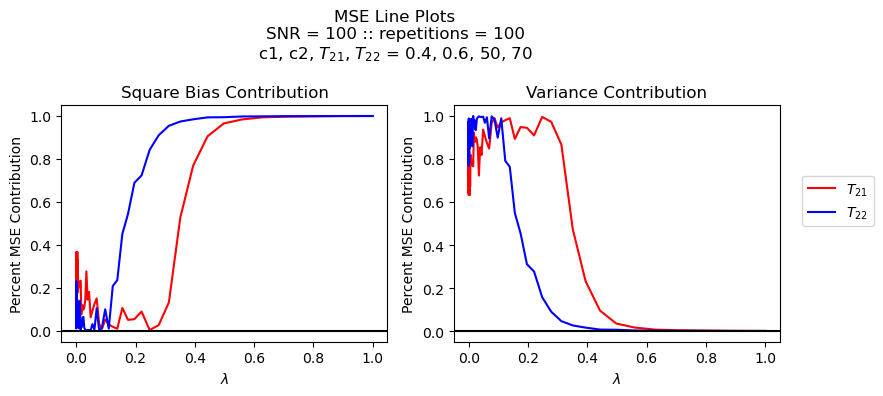

In [106]:
fig, ax = plt.subplots(1,2, figsize=(8,4), tight_layout=True)
fig.suptitle(f"MSE Line Plots\n{noise_info} :: repetitions = {repetitions}\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")

ax[0].plot(lambda_array, square_bias[:,0]/MSE[:,0], color = 'r', ls = '-', label = T21_label)
ax[0].plot(lambda_array, square_bias[:,1]/MSE[:,1], color = 'b', ls = '-', label = T22_label)
ax[0].axhline(y = 0, color = 'k')
ax[0].set_xlabel(lamb_lab)
ax[0].set_ylabel('Percent MSE Contribution')
ax[0].set_title(f'Square Bias Contribution')

ax[1].plot(lambda_array, variance[:,0]/MSE[:,0], color = 'r', ls = '-', label = T21_label)
ax[1].plot(lambda_array, variance[:,1]/MSE[:,1], color = 'b', ls = '-', label = T22_label)
ax[1].axhline(y = 0, color = 'k')
ax[1].set_xlabel(lamb_lab)
ax[1].set_ylabel('Percent MSE Contribution')
ax[1].set_title(f'Variance Contribution')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.5))